Some of the data loading and training code is taken from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

## Experiments with adaptive skip connections

The goal of this notebook is to experiment with adaptive skip connections. We trained CNNs on the CIFAR10 dataset, at first with the hope of increasing training performance using our adaptive skip weights and also to gain understanding of the role of skip connections.

Ultimately, we saw (see plots at the end) that performance doesn't really benefit from these adaptive skip connections. However the evolution of the skip weights does support the classical interpretation of skip connections as "gradient highways", as discussed in the paper.

To run this notebook in Google Colab (which we did during our project), make sure to switch the first variable to `True`


In [2]:
#IMPORTANT : set following variable to True iff you run this notebook in Google Colab
#It will allow you to save intermediate results in your Google Drive, in case you are disconnected
COLAB=False

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

SAVEPATH=''
if COLAB:
  from google.colab import drive
  SAVEPATH = '/content/drive/MyDrive/Colab Notebooks/' + SAVEPATH
  drive.mount('/content/drive/')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
#Load the data (CIFAR10)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 73467296.00it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
#Old version, no sigmoid.
RBVERSION=''
class ResidualBlock(nn.Module):
  def __init__(self, channels, skip=True, adaptive_skip=False, skip_w0=0.5):
    super().__init__()
    self.channels = channels
    self.skip = skip
    self.adaptive_skip = adaptive_skip

    self.conv1 = nn.Conv2d(channels, channels, 3, padding='same')
    self.act1 = nn.LeakyReLU()
    self.conv2 = nn.Conv2d(channels, channels, 3, padding='same')
    self.act2 = nn.LeakyReLU()

    self.skip_w = nn.Parameter(torch.tensor([skip_w0 if skip else 0.0]), requires_grad=adaptive_skip)
    print(f'ResidualBlock initialization: {self.skip_w=}')

  def forward(self, x):
    y = self.conv1(x)
    y = self.act1(y)
    y = self.conv2(y)
    y = self.act2(y)
    return (1 - self.skip_w) * y + self.skip_w * x


In [4]:
RBVERSION='2'
#In this version, the skip_w weight goes through a sigmoid to make it
#bounded between 0 and 1, which yields more interpretable result.
class ResidualBlock(nn.Module):
  def __init__(self, channels, skip=True, adaptive_skip=False, skip_w0=0.0):
    '''
    TODO
    skip_w0 : initialization value for the skip connection weight
    '''
    super().__init__()
    self.channels = channels
    self.skip = skip
    self.adaptive_skip = adaptive_skip

    self.conv1 = nn.Conv2d(channels, channels, 3, padding='same')
    self.act1 = nn.LeakyReLU()
    self.conv2 = nn.Conv2d(channels, channels, 3, padding='same')
    self.act2 = nn.LeakyReLU()

    self.skip_w = nn.Parameter(torch.tensor([skip_w0 if skip else 0.0]), requires_grad=adaptive_skip)
    print(f'ResidualBlock initialization: {self.skip_w=}')

  def forward(self, x):
    y = self.conv1(x)
    y = self.act1(y)
    y = self.conv2(y)
    y = self.act2(y)
    sig_skip_w = torch.sigmoid(self.skip_w) #in (0, 1)
    return (1 - sig_skip_w) * y + sig_skip_w * x

In [5]:
#Old version, significantly less parameters.
MVERSION=''
class Model(nn.Module):
  def __init__(self, skip=True, adaptive_skip=False, skip_w0=0.5):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 12, 3, padding='same')
    self.act1 = nn.LeakyReLU()
    self.res1 = ResidualBlock(12, skip=skip, adaptive_skip=adaptive_skip, skip_w0=skip_w0)
    self.pooling1 = nn.MaxPool2d(2) #Nx12x16x16
    self.res2 = ResidualBlock(12, skip=skip, adaptive_skip=adaptive_skip, skip_w0=skip_w0)
    self.pooling2 = nn.MaxPool2d(2) #Nx12x8x8
    self.fc = nn.Linear(768, 10)
    self.act_final = nn.LogSoftmax()

  def forward(self, x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.res1(x)
    x = self.pooling1(x)
    x = self.res2(x)
    x = self.pooling2(x)
    x = self.fc(x.view(-1, 768))
    return self.act_final(x)


In [6]:
MVERSION='2'
#More parameters, but still only 2 residual blocks.
class Model(nn.Module):
  def __init__(self, skip=True, adaptive_skip=False, skip_w0=0.0):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 24, 3, padding='same')
    self.act1 = nn.LeakyReLU()
    self.res1 = ResidualBlock(24, skip=skip, adaptive_skip=adaptive_skip, skip_w0=skip_w0)
    self.pooling1 = nn.MaxPool2d(2) #Nx24x16x16
    self.res2 = ResidualBlock(24, skip=skip, adaptive_skip=adaptive_skip, skip_w0=skip_w0)
    self.pooling2 = nn.MaxPool2d(2) #Nx24x8x8
    self.fc1 = nn.Linear(1536, 128)
    self.fc_act1 = nn.LeakyReLU()
    self.fc2 = nn.Linear(128, 10)
    self.act_final = nn.LogSoftmax()

  def forward(self, x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.res1(x)
    x = self.pooling1(x)
    x = self.res2(x)
    x = self.pooling2(x)
    x = self.fc1(x.view(-1, 1536))
    x = self.fc_act1(x)
    x = self.fc2(x)
    return self.act_final(x)


In [7]:
#Now 4 residual blocks. This allows us to see whether the skip weights are in
#increasing / decreasing order based on the depth position of the residual block.
MVERSION='3'
class Model(nn.Module):
  def __init__(self, skip=True, adaptive_skip=False, skip_w0=0.0):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 24, 3, padding='same')
    self.act1 = nn.LeakyReLU()
    self.res1 = ResidualBlock(24, skip=skip, adaptive_skip=adaptive_skip, skip_w0=skip_w0)
    self.pooling1 = nn.MaxPool2d(2) #Nx6x16x16
    self.res2 = ResidualBlock(24, skip=skip, adaptive_skip=adaptive_skip, skip_w0=skip_w0)
    self.res3 = ResidualBlock(24, skip=skip, adaptive_skip=adaptive_skip, skip_w0=skip_w0)
    self.pooling2 = nn.MaxPool2d(2) #Nx24x8x8
    self.res4 = ResidualBlock(24, skip=skip, adaptive_skip=adaptive_skip, skip_w0=skip_w0)

    self.fc1 = nn.Linear(1536, 128)
    self.fc_act1 = nn.LeakyReLU()
    self.fc2 = nn.Linear(128, 10)
    self.act_final = nn.LogSoftmax()

  def forward(self, x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.res1(x)
    x = self.pooling1(x)
    x = self.res2(x)
    x = self.res3(x)
    x = self.pooling2(x)
    x = self.res4(x)
    x = self.fc1(x.view(-1, 1536))
    x = self.fc_act1(x)
    x = self.fc2(x)
    return self.act_final(x)

In [8]:
VERSION = RBVERSION + MVERSION
# Used as a prefix for all the saved files to make
# sure it is clear which residual block and which model were used.

In [9]:
def test(net, testloader, return_loss=True):
  correct = 0
  total = 0
  criterion = nn.CrossEntropyLoss()
  total_loss = 0.0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)
          # calculate outputs by running images through the network
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          if return_loss:
            total_loss += criterion(outputs, labels).item()

  if not return_loss:
    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
    return correct / total
  else:
    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %, loss: {total_loss}')
    return correct / total, total_loss

In [10]:
def train(net, criterion, optimizer, trainloader, epochs, device, loss_history=None, test_each_epoch=False, testloader=None, acc_history=None, testloss_history=None, skip_w_history=None):
  print_freq = 100

  for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        if skip_w_history is not None:
          skip_w_history.append((net.res1.skip_w.item(), net.res2.skip_w.item(),
                                 net.res3.skip_w.item(), net.res4.skip_w.item()))

        if (i+1) % print_freq == 0:    # print every 100 mini-batches
          print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f}')
          running_loss = 0.0
          if skip_w_history:
            print(f'[{epoch + 1}, {i + 1:5d}] skip_w: {skip_w_history[-1]}')

        if loss_history is not None:
          loss_history.append(loss.item())


    if test_each_epoch:
      acc, testloss = test(net, testloader, return_loss=True)
      acc_history.append(acc)
      testloss_history.append(testloss)

print('Finished Training')

Finished Training


In [ ]:
####################################
### Test with regular skip connections
####################################

print(f"Using {device=}")
net = Model(skip=True, adaptive_skip=False)
net.to(device)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=1e-2)
optimizer = optim.Adam(net.parameters())
loss_history = []
acc_history = []
testloss_history = []
skip_w_history = None

#Train the model (and test it on the testdata after each epoch)
train(net, criterion, optimizer, trainloader, epochs=20, device=device, loss_history=loss_history,
      test_each_epoch=True, testloader=testloader, acc_history=acc_history, testloss_history=testloss_history,
      skip_w_history=skip_w_history)

#Save the training/testing stats and the model
torch.save(net.state_dict(), SAVEPATH+VERSION+"regskip.pth")
torch.save(loss_history, SAVEPATH+VERSION+"regskip_trainingloss.pth")
torch.save(acc_history, SAVEPATH+VERSION+"regskip_testacc.pth")
torch.save(testloss_history, SAVEPATH+VERSION+"regskip_testloss.pth")

Using device=device(type='cuda', index=0)
ResidualBlock initialization: self.skip_w=Parameter containing:
tensor([0.])
ResidualBlock initialization: self.skip_w=Parameter containing:
tensor([0.])
ResidualBlock initialization: self.skip_w=Parameter containing:
tensor([0.])
ResidualBlock initialization: self.skip_w=Parameter containing:
tensor([0.])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[1,   100] loss: 2.020
[1,   200] loss: 1.664
[1,   300] loss: 1.499
Accuracy of the network on the 10000 test images: 49 %, loss: 109.40010273456573
[2,   100] loss: 1.338
[2,   200] loss: 1.260
[2,   300] loss: 1.196
Accuracy of the network on the 10000 test images: 58 %, loss: 92.58051282167435
[3,   100] loss: 1.094
[3,   200] loss: 1.047
[3,   300] loss: 1.047
Accuracy of the network on the 10000 test images: 64 %, loss: 79.18122082948685
[4,   100] loss: 0.937
[4,   200] loss: 0.913
[4,   300] loss: 0.890
Accuracy of the network on the 10000 test images: 67 %, loss: 72.98730564117432
[5,   100] loss: 0.819
[5,   200] loss: 0.810
[5,   300] loss: 0.808
Accuracy of the network on the 10000 test images: 70 %, loss: 67.3257822394371
[6,   100] loss: 0.730
[6,   200] loss: 0.723
[6,   300] loss: 0.729
Accuracy of the network on the 10000 test images: 71 %, loss: 64.55813890695572
[7,   100] loss: 0.662
[7,   200] loss: 0.642
[7,   300] loss: 0.663
Accuracy of the network on the 10000 

In [ ]:
####################################
### Test with adaptive skip connections
####################################
print(f"Using {device=}")
net = Model(skip=True, adaptive_skip=True)
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
loss_history = []
acc_history = []
testloss_history = []
skip_w_history = []

#Train the model (and test it on the testdata after each epoch)
train(net, criterion, optimizer, trainloader, epochs=20, device=device, loss_history=loss_history,
      test_each_epoch=True, testloader=testloader, acc_history=acc_history, testloss_history=testloss_history,
      skip_w_history=skip_w_history)

#Save the training/testing stats and the model
torch.save(net.state_dict(), SAVEPATH+VERSION+"adaskip.pth")
torch.save(loss_history, SAVEPATH+VERSION+"adaskip_trainingloss.pth")
torch.save(acc_history, SAVEPATH+VERSION+"adaskip_testacc.pth")
torch.save(testloss_history, SAVEPATH+VERSION+"adaskip_testloss.pth")
torch.save(skip_w_history, SAVEPATH+VERSION+"adaskip_skipw.pth")


Using device=device(type='cuda', index=0)
ResidualBlock initialization: self.skip_w=Parameter containing:
tensor([0.], requires_grad=True)
ResidualBlock initialization: self.skip_w=Parameter containing:
tensor([0.], requires_grad=True)
ResidualBlock initialization: self.skip_w=Parameter containing:
tensor([0.], requires_grad=True)
ResidualBlock initialization: self.skip_w=Parameter containing:
tensor([0.], requires_grad=True)
[1,   100] loss: 2.029
[1,   100] skip_w: (0.045432329177856445, 0.05605100467801094, 0.08723928779363632, 0.06555446237325668)
[1,   200] loss: 1.709
[1,   200] skip_w: (0.07605496048927307, 0.09152398258447647, 0.12946359813213348, 0.10648827999830246)
[1,   300] loss: 1.536
[1,   300] skip_w: (0.08689285069704056, 0.12209170311689377, 0.1351161152124405, 0.13829705119132996)
Accuracy of the network on the 10000 test images: 49 %, loss: 108.45085871219635
[2,   100] loss: 1.364
[2,   100] skip_w: (0.08920768648386002, 0.1596975177526474, 0.13761696219444275, 0.1

In [ ]:
####################################
### Test with no skip connections
####################################

print(f"Using {device=}")
net = Model(skip=False, adaptive_skip=False)
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
loss_history = []
acc_history = []
testloss_history = []
skip_w_history = []

#Train the model (and test it on the testdata after each epoch)
train(net, criterion, optimizer, trainloader, epochs=1, device=device, loss_history=loss_history,
      test_each_epoch=True, testloader=testloader, acc_history=acc_history, testloss_history=testloss_history,
      skip_w_history=skip_w_history)

#Save the training/testing stats and the model
torch.save(net.state_dict(), SAVEPATH+VERSION+"noskip.pth")
torch.save(loss_history, SAVEPATH+VERSION+"noskip_trainingloss.pth")
torch.save(acc_history, SAVEPATH+VERSION+"noskip_testacc.pth")
torch.save(testloss_history, SAVEPATH+VERSION+"noskip_testloss.pth")


[(-0.0009998449822887778, 0.04111999273300171, 0.0743759423494339, 0.08322025090456009, 0.09106413275003433, 0.0877133309841156, 0.08723807334899902, 0.08307639509439468, 0.07198365032672882, 0.062368202954530716, 0.04881621524691582, 0.03572055324912071, 0.022987553849816322, 0.008116234093904495, -0.005973087158054113, -0.021589912474155426, -0.030576180666685104, -0.04205548018217087, -0.05263091251254082, -0.06481049209833145, -0.0723077580332756, -0.08020544052124023, -0.09370308369398117, -0.10210054367780685, -0.11172531545162201, -0.12386806309223175, -0.13039395213127136, -0.1379694640636444, -0.1502835899591446, -0.15985845029354095, -0.16267013549804688, -0.17315568029880524, -0.18282705545425415, -0.18910230696201324, -0.19504578411579132, -0.2059539407491684, -0.2147710770368576, -0.21880531311035156, -0.22735512256622314, -0.22422191500663757, -0.23850104212760925, -0.2434079498052597, -0.24886631965637207, -0.256035178899765, -0.26534366607666016, -0.2691609561443329, -0

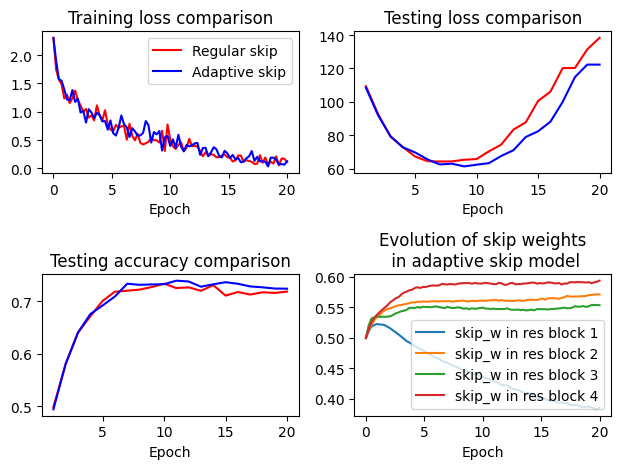

In [ ]:
#Plot the stats about training on the first three plots, and the skip weights on the last one.
fig, axs = plt.subplots(2, 2)

sample_freq = 90 #only plot every sample_freq-th training loss to avoid overloadig the plot...
regskip_trainingloss = torch.load(SAVEPATH+VERSION+"regskip_trainingloss.pth")[::sample_freq]
adaskip_trainingloss = torch.load(SAVEPATH+VERSION+"adaskip_trainingloss.pth")[::sample_freq]

regskip_testloss = torch.load(SAVEPATH+VERSION+"regskip_testloss.pth")
adaskip_testloss = torch.load(SAVEPATH+VERSION+"adaskip_testloss.pth")

regskip_acc = torch.load(SAVEPATH+VERSION+"regskip_testacc.pth")
adaskip_acc = torch.load(SAVEPATH+VERSION+"adaskip_testacc.pth")

skipw = list(zip(*torch.load(SAVEPATH+VERSION+"adaskip_skipw.pth")[::sample_freq]))
print(skipw)

x_axis = torch.linspace(0, 20, len(adaskip_trainingloss))

axs[0][0].set_title("Training loss comparison")
axs[0][0].plot(x_axis, regskip_trainingloss, color="r", label="Regular skip")
axs[0][0].plot(x_axis, adaskip_trainingloss, color="b", label="Adaptive skip")
axs[0][0].legend()

axs[0][1].set_title("Testing loss comparison")
axs[0][1].plot(range(1, 21), regskip_testloss, color="r")
axs[0][1].plot(range(1, 21), adaskip_testloss, color="b")

axs[1][0].set_title("Testing accuracy comparison")
axs[1][0].plot(range(1, 21), regskip_acc, color="r")
axs[1][0].plot(range(1, 21), adaskip_acc, color="b")

axs[1][1].set_title("Evolution of skip weights\n in adaptive skip model")
#Be careful to only keep the sigmoid if it is used in the residual block, which was not the case in the first version.
axs[1][1].plot(x_axis, torch.sigmoid(torch.tensor(skipw[0])), label="skip_w in res block 1")
axs[1][1].plot(x_axis, torch.sigmoid(torch.tensor(skipw[1])), label="skip_w in res block 2")
axs[1][1].plot(x_axis, torch.sigmoid(torch.tensor(skipw[2])), label="skip_w in res block 3")
axs[1][1].plot(x_axis, torch.sigmoid(torch.tensor(skipw[3])), label="skip_w in res block 4")
axs[1][1].legend()

for ax in axs.flatten():
  ax.set_xlabel("Epoch")
  #ax.label_outer()

fig.tight_layout()
plt.show()



[(-0.0009998449822887778, 0.017745204269886017, 0.024116231128573418, 0.03540399298071861, 0.04606374353170395, 0.05875391140580177, 0.06635846197605133, 0.07406120747327805, 0.07598375529050827, 0.08111356943845749, 0.08162619918584824, 0.08348279446363449, 0.08756306767463684, 0.08587310463190079, 0.08833252638578415, 0.08985443413257599, 0.09050437808036804, 0.08849331736564636, 0.0877133309841156, 0.08923549205064774, 0.09122259169816971, 0.08807969093322754, 0.08640897274017334, 0.0868057981133461, 0.08510322868824005, 0.08285495638847351, 0.08039697259664536, 0.0770641416311264, 0.07324706017971039, 0.07135852426290512, 0.06998809427022934, 0.06769375503063202, 0.06260416656732559, 0.060036834329366684, 0.05657712370157242, 0.0533117800951004, 0.04881621524691582, 0.04494697228074074, 0.040202051401138306, 0.03628339245915413, 0.035366881638765335, 0.03143816441297531, 0.028031332418322563, 0.0234958678483963, 0.02121594175696373, 0.015933092683553696, 0.012127484194934368, 0.007

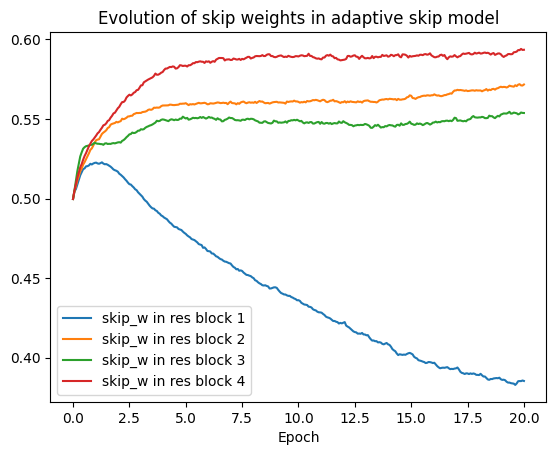

In [11]:
#Only show the plot with the skip weights, for 4 residual blocks.
sample_freq=25
skipw = list(zip(*torch.load(SAVEPATH+VERSION+"adaskip_skipw.pth")[::sample_freq]))
print(skipw)

x_axis = torch.linspace(0, 20, len(skipw[0]))

plt.title("Evolution of skip weights in adaptive skip model")
plt.plot(x_axis, torch.sigmoid(torch.tensor(skipw[0])), label="skip_w in res block 1")
plt.plot(x_axis, torch.sigmoid(torch.tensor(skipw[1])), label="skip_w in res block 2")
plt.plot(x_axis, torch.sigmoid(torch.tensor(skipw[2])), label="skip_w in res block 3")
plt.plot(x_axis, torch.sigmoid(torch.tensor(skipw[3])), label="skip_w in res block 4")
plt.xlabel("Epoch")
plt.legend()

plt.show()